In [1]:
import json
import sys
from train_cnfqi import run
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt 
import numpy as np
import torch
import random

# Interpretability

In [ ]:
import shap
printed_bg, printed_fg, performance, nfq_agent, X, X_test = run(verbose=False, is_contrastive=True, evaluations=2, force_left=5)

In [ ]:
group_0 = []
group_1 = []
for x, g in zip(X_test[0], X_test[1]):
    if g == 0:
        group_0.append(x.cpu().detach().numpy())
    else:
        group_1.append(x.cpu().detach().numpy())

In [ ]:
group_0 = torch.Tensor(np.asarray(group_0))
group_1 = torch.Tensor(np.asarray(group_1))

In [ ]:
e = shap.DeepExplainer(nfq_agent._nfq_net, X[0])
shap_values = e.shap_values(group_0[:10])
shap_values

In [ ]:
explanation = shap.Explanation(shap_values)
explanation.data = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Velocity at Tip", "Action"]

In [ ]:
shap.plots.bar(shap.Explanation(shap_values), show=False)
plt.title("Background SHAP Values")
#plt.yticks(["Feature 0", "Feature 1", "Feature 2", "Feature 3", "Feature 4"], ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Velocity at Tip", "Action"])

# Force left=0

In [ ]:
import json
from train_cnfqi import run, warm_start, transfer_learning
num_iter=10
results = {'fqi': {}, 'cfqi': {}, 'warm_start': {}, 'tl': {}}
for i in range(num_iter):
    print(str(i))
    performance = run(verbose=False, is_contrastive=True, evaluations=2, force_left=0)
    results['cfqi'][i] = performance
    performance = run(verbose=False, is_contrastive=False, evaluations=2, force_left=0)
    results['fqi'][i] = performance
    performance = warm_start(verbose=False, is_contrastive=False, evaluations=2, force_left=0)
    results['warm_start'][i] = performance
    performance = transfer_learning(verbose=False, is_contrastive=False, evaluations=2, force_left=0)
    results['tl'][i] = performance
    
    
    with open('force_left=0.json', 'w') as f:
        json.dump(results, f)  

In [ ]:
fqi_results = []
cfqi_results = []
ws_results = []
tl_results = []
for alg in ['cfqi', 'fqi', 'warm_start', 'tl']:
    for key in results[alg]:
        if alg == 'fqi':
            fqi_results.extend(results[alg][key])
        elif alg == 'cfqi':
            cfqi_results.extend(results[alg][key])
        elif alg == 'warm_start':
            ws_results.extend(results[alg][key])
        else:
            tl_results.extend(results[alg][key])

In [ ]:
sns.distplot(fqi_results, label='FQI')
sns.distplot(cfqi_results, label='CFQI')
sns.distplot(ws_results, label='Warm Start')
sns.distplot(tl_results, label='Transfer Learning')
plt.legend()
plt.xlabel("Steps survived")
plt.title("Force left = 0")

# Force Left vs Performance

In [3]:
import json
from train_cnfqi import run, warm_start, transfer_learning
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

num_iter=2
results = {}
for i in range(0, 11):
    results[i] = {}
    results[i]['cfqi'] = {}
    results[i]['fqi'] = {}
    results[i]['warm_start'] = {}
    results[i]['tl'] = {}

for i in range(num_iter):
    for f in range(0, 11):
        print(str(i) + str(f))
        performance_fg, performance_bg = run(verbose=False, is_contrastive=True, evaluations=2, force_left=f)
        results[f]['cfqi'][i] = (performance_fg, performance_bg)
        performance_fg, performance_bg = run(verbose=False, is_contrastive=False, evaluations=2, force_left=f)
        results[f]['fqi'][i] = (performance_fg, performance_bg)
        performance_fg, performance_bg = warm_start(verbose=False, is_contrastive=False, evaluations=2, force_left=f)
        results[f]['warm_start'][i] = (performance_fg, performance_bg)
        performance_fg, performance_bg = transfer_learning(verbose=False, is_contrastive=False, evaluations=2, force_left=f)
        results[f]['tl'][i] = (performance_fg, performance_bg)
        
    
    with open('force_left_v_performance.json', 'w') as f:
        json.dump(results, f)  

00


/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Fg trained after 42 epochs
BG stayed up for steps:  [1000, 1000]
FG stayed up for steps:  [1000, 1000]
Fg trained after 333 epochs
BG stayed up for steps:  [1000, 1000]
FG stayed up for steps:  [598, 1000]
02
Fg trained after 0 epochs
BG stayed up for steps:  [24, 20]
FG stayed up for steps:  [19, 20]
Fg trained after 0 epochs
BG stayed up for steps:  [1000, 1000]
FG stayed up for steps:  [1000, 1000]
04
Fg trained after 63 epochs
BG stayed up for steps:  [1000, 1000]
FG stayed up for steps:  [1000, 1000]
Fg trained after 0 epochs
BG stayed up for steps:  [58, 66]
FG stayed up for steps:  [56, 42]
06
Fg trained after 301 epochs
BG stayed up for steps:  [1000, 1000]
FG stayed up for steps:  [1000, 1000]
Fg trained after 0 epochs
BG stayed up for steps:  [87, 46]
FG stayed up for steps:  [47, 59]
08
Fg trained after 0 epochs
BG stayed up for steps:  [22, 25]
FG stayed up for steps:  [17, 18]
Fg trained after 0 epochs
BG stayed up for steps:  [59, 54]
FG stayed up for steps:  [49, 32]
010

In [10]:
results[0]['cfqi'][0]

[1000, 1000]

In [17]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def plot_performance(results, ds='bg'):
    c_success = []
    f_success = []
    w_success = []
    t_success = []
    c_errs = []
    f_errs = []
    w_errs = []
    t_errs = []
    if ds == 'bg':
        ind = 1
    else:
        ind = 0
    for i in range(0, 11):
        cfqi_perf = []
        fqi_perf = []
        ws_perf = []
        tl_perf = []
        for key in results[i]['fqi']:
            fqi_perf.extend(results[i]['fqi'][key][ind])
        for key in results[i]['cfqi']:
            cfqi_perf.extend(results[i]['cfqi'][key][ind])
        for key in results[i]['warm_start']:
            ws_perf.extend(results[i]['warm_start'][key][ind])
        for key in results[i]['tl']:
            tl_perf.extend(results[i]['tl'][key][ind])

        c_success.append(np.mean(cfqi_perf))
        f_success.append(np.mean(fqi_perf))
        w_success.append(np.mean(ws_perf))
        t_success.append(np.mean(tl_perf))
        m, h = mean_confidence_interval(cfqi_perf)
        c_errs.append(h)
        m, h = mean_confidence_interval(fqi_perf)
        f_errs.append(h)
        m, h = mean_confidence_interval(ws_perf)
        w_errs.append(h)
        m, h = mean_confidence_interval(tl_perf)
        t_errs.append(h) 

    x = [k for k in range(0, 11)]
    plt.figure(figsize=(10, 4))
    sns.scatterplot(x, c_success, label='CFQI')
    plt.errorbar(x, c_success ,yerr=c_errs, linestyle="None")
    sns.scatterplot(x, f_success, label='FQI')
    plt.errorbar(x, f_success ,yerr=f_errs, linestyle="None")
    sns.scatterplot(x, w_success, label='Warm Start')
    plt.errorbar(x, w_success ,yerr=w_errs, linestyle="None")
    sns.scatterplot(x, t_success, label='Transfer Learning')
    plt.errorbar(x, t_success ,yerr=t_errs, linestyle="None")
    if ds == 'bg':
        plt.title("Background Dataset: Performance of CFQI, FQI, Warm Start, Transfer Learning when force on cart is modified")
    else:
        plt.title("Foreground Dataset: Performance of CFQI, FQI, Warm Start, Transfer Learning when force on cart is modified")
    plt.xlabel("Force Left")
    plt.ylabel("Steps Survived")
    plt.show()

/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error 

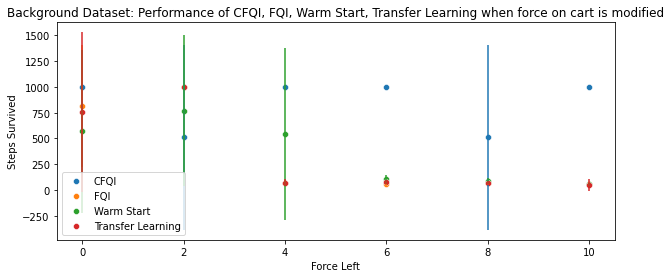

/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error 

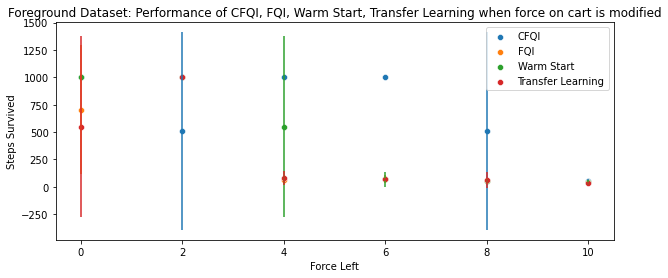

In [18]:
plot_performance(results, ds='bg')
plot_performance(results, ds='fg')

# Shuffle test

In [ ]:
import configargparse
import torch
import torch.optim as optim

from environments import CartPoleRegulatorEnv
from environments import CartEnv
from environments import AcrobotEnv
from models.agents import NFQAgent
from models.networks import NFQNetwork, ContrastiveNFQNetwork
# from simulated_fqi import NFQAgent
# from simulated_fqi import NFQNetwork, ContrastiveNFQNetwork
from util import get_logger, close_logger, load_models, make_reproducible, save_models
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random

In [ ]:
def shuffle_test(verbose=False, epoch=1000, train_env_max_steps=100, eval_env_max_steps=3000, discount=0.95, 
                 init_experience=200, increment_experience=0, hint_to_goal=0, evaluations=5, force_left=0, random_seed=1234):
    # Setup environment
    bg_cart_mass = 1.0
    fg_cart_mass = 1.0
    is_contrastive = True
    train_env_bg = CartPoleRegulatorEnv(group=0, masscart=bg_cart_mass, mode="train", force_left=force_left, is_contrastive=is_contrastive)
    train_env_fg = CartPoleRegulatorEnv(group=1, masscart=fg_cart_mass, mode="train", force_left=force_left, is_contrastive=is_contrastive)
    eval_env_bg = CartPoleRegulatorEnv(group=0, masscart=bg_cart_mass, mode="eval", force_left=force_left, is_contrastive=is_contrastive)
    eval_env_fg = CartPoleRegulatorEnv(group=1, masscart=fg_cart_mass, mode="eval", force_left=force_left, is_contrastive=is_contrastive)

    # Log to File, Console, TensorBoard, W&B
    logger = get_logger()

    # Setup agent
    nfq_net = ContrastiveNFQNetwork(state_dim=train_env_bg.state_dim, is_contrastive=is_contrastive)
    # optimizer = optim.Rprop(nfq_net.parameters())

    if is_contrastive:
        optimizer = optim.Adam(itertools.chain(nfq_net.layers_shared.parameters(), nfq_net.layers_last_shared.parameters()), lr=1e-1)
    else:
        optimizer = optim.Adam(nfq_net.parameters(), lr=1e-1)

    nfq_agent = NFQAgent(nfq_net, optimizer)

    # NFQ Main loop
    # A set of transition samples denoted as D
    bg_rollouts = []
    fg_rollouts = []
    if init_experience > 0:
        for _ in range(init_experience):
            bg_group = random.choice([0, 1])
            fg_group = random.choice([0, 1])
            rollout_bg, episode_cost = train_env_bg.generate_rollout(
                None, render=False, group=bg_group
            )
            rollout_fg, episode_cost = train_env_fg.generate_rollout(
                None, render=False, group=fg_group
            )
            bg_rollouts.extend(rollout_bg)
            fg_rollouts.extend(rollout_fg)
    bg_rollouts.extend(fg_rollouts)
    all_rollouts = bg_rollouts.copy()

    bg_rollouts_test = []
    fg_rollouts_test = []
    if init_experience > 0:
        for _ in range(init_experience):
            bg_group = random.choice([0, 1])
            fg_group = random.choice([0, 1])
            rollout_bg, episode_cost = eval_env_bg.generate_rollout(
                None, render=False, group=bg_group
            )
            rollout_fg, episode_cost = eval_env_fg.generate_rollout(
                None, render=False, group=fg_group
            )
            bg_rollouts_test.extend(rollout_bg)
            fg_rollouts_test.extend(rollout_fg)
    bg_rollouts_test.extend(fg_rollouts)
    all_rollouts_test = bg_rollouts_test.copy()

    state_action_b, target_q_values, groups = nfq_agent.generate_pattern_set(all_rollouts_test)
    X_test = state_action_b
    test_groups = groups

    bg_success_queue = [0] * 3
    fg_success_queue = [0] * 3
    epochs_fg = 0
    eval_fg = 0
    for epoch in range(epoch + 1):

        state_action_b, target_q_values, groups = nfq_agent.generate_pattern_set(all_rollouts)
        X = state_action_b
        train_groups = groups

        if not nfq_net.freeze_shared:
            loss = nfq_agent.train((state_action_b, target_q_values, groups))

        eval_episode_length_fg, eval_success_fg, eval_episode_cost_fg = 0, 0, 0
        if nfq_net.freeze_shared:
            eval_fg += 1

            if eval_fg > 50:
                loss = nfq_agent.train((state_action_b, target_q_values, groups))

        if is_contrastive:
            # import ipdb; ipdb.set_trace()
            if nfq_net.freeze_shared:
                eval_episode_length_fg, eval_success_fg, eval_episode_cost_fg = nfq_agent.evaluate(
                    eval_env_fg, render=False
                )
                for param in nfq_net.layers_fg.parameters():
                    assert param.requires_grad == True
                for param in nfq_net.layers_last_fg.parameters():
                    assert param.requires_grad == True
                for param in nfq_net.layers_shared.parameters():
                    assert param.requires_grad == False
                for param in nfq_net.layers_last_shared.parameters():
                    assert param.requires_grad == False
            else:

                for param in nfq_net.layers_fg.parameters():
                    assert param.requires_grad == False
                for param in nfq_net.layers_last_fg.parameters():
                    assert param.requires_grad == False
                for param in nfq_net.layers_shared.parameters():
                    assert param.requires_grad == True
                for param in nfq_net.layers_last_shared.parameters():
                    assert param.requires_grad == True
                eval_episode_length_bg, eval_success_bg, eval_episode_cost_bg = nfq_agent.evaluate(
                    eval_env_bg, render=False
                )


        else:
            eval_episode_length_bg, eval_success_bg, eval_episode_cost_bg = nfq_agent.evaluate(
                eval_env_bg, render=False
            )
            eval_episode_length_fg, eval_success_fg, eval_episode_cost_fg = nfq_agent.evaluate(
                eval_env_fg, render=False
            )

        bg_success_queue = bg_success_queue[1:]
        bg_success_queue.append(1 if eval_success_bg else 0)

        fg_success_queue = fg_success_queue[1:]
        fg_success_queue.append(1 if eval_success_fg else 0)

        printed_bg = False
        printed_fg = False

        if sum(bg_success_queue) == 3 and not nfq_net.freeze_shared == True:
            if epochs_fg == 0:
                epochs_fg = epoch
            printed_bg = True
            nfq_net.freeze_shared = True
            if verbose:
                print("FREEZING SHARED")
            if is_contrastive:
                for param in nfq_net.layers_shared.parameters():
                    param.requires_grad = False
                for param in nfq_net.layers_last_shared.parameters():
                    param.requires_grad = False
                for param in nfq_net.layers_fg.parameters():
                    param.requires_grad = True
                for param in nfq_net.layers_last_fg.parameters():
                    param.requires_grad = True
            # else:
            #     for param in nfq_net.layers_fg.parameters():
            #         param.requires_grad = False
            #     for param in nfq_net.layers_last_fg.parameters():
            #         param.requires_grad = False

                optimizer = optim.Adam(itertools.chain(nfq_net.layers_fg.parameters(), nfq_net.layers_last_fg.parameters()), lr=1e-1)
                nfq_agent._optimizer = optimizer
            # break

        # Print current status
        if verbose:
            logger.info(
                # "Epoch {:4d} | Eval BG {:4d} / {:4f} | Eval FG {:4d} / {:4f} | Train Loss {:.4f}".format(
                #     epoch, eval_env_bg.success_step, eval_episode_cost_bg, eval_env_fg.success_step, eval_episode_cost_fg, loss
                # )
                "Epoch {:4d} | Eval BG {:4d} / {:4f} | Eval FG {:4d} / {:4f} | Train Loss {:.4f}".format(
                    epoch, eval_episode_length_bg, eval_episode_cost_bg, eval_episode_length_fg, eval_episode_cost_fg, loss
                )
            )
        if sum(fg_success_queue) == 3:
            printed_fg = True
            if verbose:
                logger.info(
                    "Epoch {:4d} | Total Cycles {:6d} | Total Cost {:4.2f}".format(
                        epoch, len(all_rollouts), total_cost
                    )
                )
            break

    eval_env_bg.step_number = 0
    eval_env_fg.step_number = 0

    eval_env_bg.max_steps = 1000
    eval_env_fg.max_steps = 1000

    performance = []
    num_steps_bg = []
    num_steps_fg = []
    total = 0
    for it in range(evaluations):

        # eval_env_bg.save_gif = True
        eval_episode_length_bg, eval_success_bg, eval_episode_cost_bg = nfq_agent.evaluate(eval_env_bg, True)
        # eval_env_bg.create_gif()
        if verbose:
            print(eval_episode_length_bg, eval_success_bg)
        num_steps_bg.append(eval_episode_length_bg)
        performance.append(eval_episode_length_bg)
        total += 1
        train_env_bg.close()
        eval_env_bg.close()

        # eval_env_fg.save_gif = True
        eval_episode_length_fg, eval_success_fg, eval_episode_cost_fg = nfq_agent.evaluate(eval_env_fg, True)
        # eval_env_fg.create_gif()
        if verbose:
            print(eval_episode_length_fg, eval_success_fg)
        num_steps_fg.append(eval_episode_length_fg)
        performance.append(eval_episode_length_fg)
        total += 1
        train_env_fg.close()
        eval_env_fg.close()
    print("Fg trained after " + str(epochs_fg) + " epochs")
    print("BG stayed up for steps: ", num_steps_bg)
    print("FG stayed up for steps: ", num_steps_fg)
    return num_steps_bg, num_steps_fg

In [ ]:
performance = {'fg': [], 'bg': []}
num_iter = 10
for i in range(num_iter):
    print(str(i))
    bg_perf, fg_perf = shuffle_test()
    performance['fg'].extend(fg_perf)
    performance['bg'].extend(bg_perf)
    with open('shuffle_test.json', 'w') as f:
        json.dump(performance, f)

In [ ]:
plt.title("Shuffle Test")
sns.distplot(performance['fg'], label='Foreground')
sns.distplot(performance['bg'], label='Background')
plt.legend()
plt.xlabel("Steps Survived")